# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [442]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [443]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [444]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [445]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

train_data[0]
# train_labels

(7000, 126) (1124, 126)


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0.])

### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

1
[0.16404331]
---
2
[0.16404331 0.13323479]
---
3
[0.16404331 0.13323479 0.10173457]
---
4
[0.16404331 0.13323479 0.10173457 0.07063356]
---
5
[0.16404331 0.13323479 0.10173457 0.07063356 0.03866646]
---
10
[0.16404331 0.13323479 0.10173457 0.07063356 0.03866646 0.03680804
 0.03128239 0.02733736 0.0261649  0.02230907]
---
20
[0.16404331 0.13323479 0.10173457 0.07063356 0.03866645 0.03680804
 0.03128234 0.02733729 0.02616484 0.02230927 0.02048027 0.01868228
 0.01734108 0.01684157 0.01518478 0.01508274 0.0142793  0.01410715
 0.01323839 0.01143219]
---
30
[0.16404331 0.13323479 0.10173457 0.07063356 0.03866646 0.03680804
 0.03128239 0.02733737 0.0261649  0.02230942 0.02048172 0.0186833
 0.01734407 0.01684358 0.01518802 0.01508593 0.01429105 0.01411999
 0.01325013 0.0114634  0.01070922 0.0106565  0.01040843 0.00991679
 0.00906605 0.00868741 0.00795282 0.0077212  0.0073537  0.0069701 ]
---
40
[0.16404331 0.13323479 0.10173457 0.07063356 0.03866646 0.03680804
 0.03128239 0.02733737 0.026164

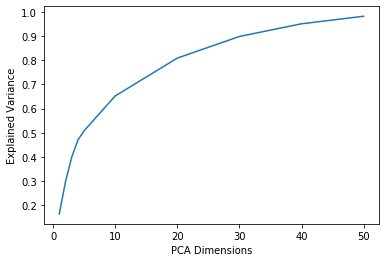

In [452]:
def P1():
    k = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    total_var = []

#     For loop to iterate over all values for k
    for item in k:
        pca = PCA(n_components = item)
        pca.fit(train_data)
        print(item)
        print(pca.explained_variance_ratio_)
        print("---")
        total_var.append(sum(pca.explained_variance_ratio_))

#     Plot the total of explained variance
    plt.plot(k, total_var) 
    plt.xlabel("PCA Dimensions") 
    plt.ylabel("Explained Variance") 


P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

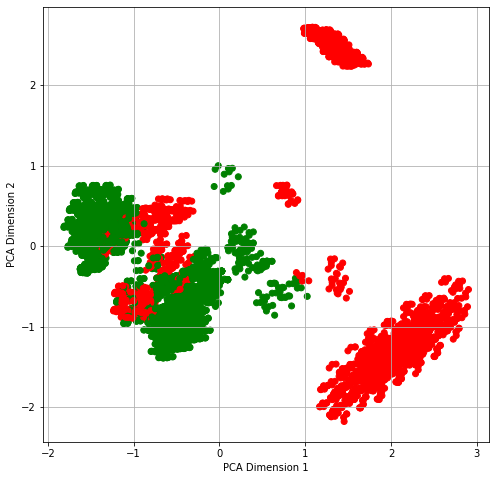

In [453]:
def P2():
    
#     Run PCA
    pca = PCA(n_components = 2)
    X1 = pca.fit_transform(train_data)
    
#     Set up grid
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1, 1)
    
#     Plot two dimensions
    ax.scatter(X1[:,0], X1[:,1], c = np.where(train_labels==1, 'r', 'g'))

    ax.grid()
    plt.xlabel("PCA Dimension 1") # Text for X-Axis
    plt.ylabel("PCA Dimension 2") # Text for Y-Axis


P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

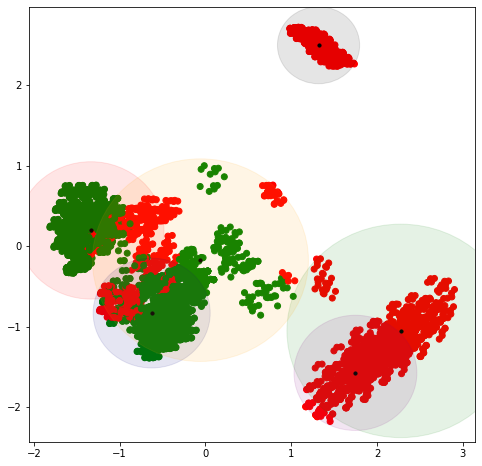

In [448]:
import math
def P3():
    
#   Fit the PCA and Kmeans
    pca = PCA(n_components = 2)
    X1 = pca.fit_transform(train_data)
    kmeans = KMeans(n_clusters=6, random_state=0).fit(X1)

    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1, 1)
    colors = ['black', 'red', 'green', 'navy', 'purple', 'orange']
    
#   Plot the points and the centers of the clusters
    plt.scatter(X1[:,0], X1[:,1], c = np.where(train_labels==1, 'r', 'g'))
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='black')
    
#   Lin alg norm was not giving me full circles, so had to switch to caculating Euclidean distance by hand
#     Iterate through all the clusters
    for index, centroids in enumerate(kmeans.cluster_centers_):
        clusterPoints = X1[(kmeans.labels_==index)]

#         Find the maximum value in each cluster using Euclidean distance
        maximum_val = 0
        for points in clusterPoints:  
            x_value = (points[0] - centroids[0])
            y_value = (points[1] - centroids[1])
            if math.sqrt(x_value*x_value + y_value*y_value) > maximum_val:
                maximum_val = math.sqrt(x_value*x_value + y_value*y_value)
        
#          Assign the radius to the max point
        cluster_circle = plt.Circle((centroids[0],centroids[1]), 
                                    maximum_val, color = colors[index], alpha = 0.1)
        ax.add_artist(cluster_circle)

P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

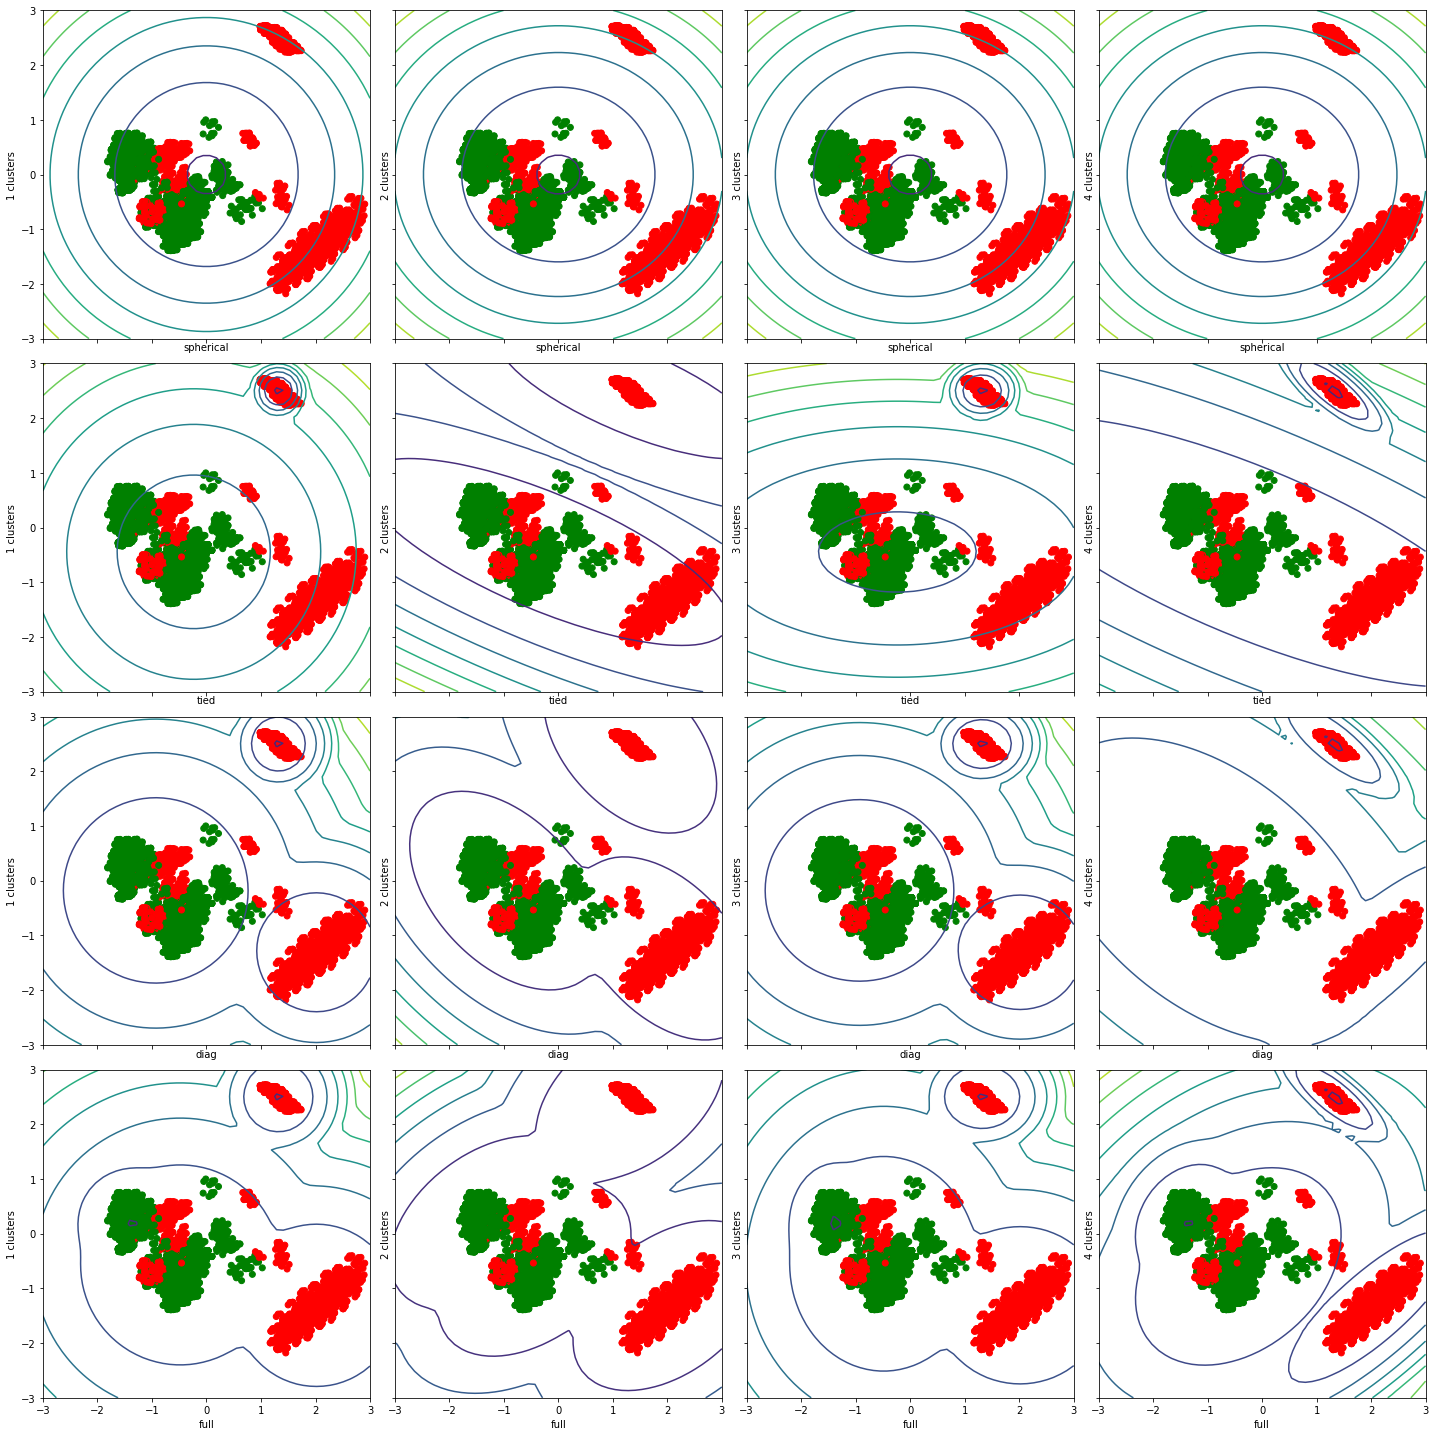

In [449]:
def P4():
#     Fit PCA model
    pca = PCA(n_components = 2)
    X1 = pca.fit_transform(train_data)
    
#     Set up grid
    fig, ax = plt.subplots(4, 4, figsize = (20, 20), sharex=True, sharey=True)

#     Iterate over the cov matrix and amount of mixture components
    for index, covariance in enumerate(['spherical', 'tied', 'diag', 'full']):
        for number in range(1, 5):
            
#             Create the plot with labels
            ax[number-1][index].scatter(X1[:, 0], X1[:, 1], c = np.where(train_labels==1, 'r', 'g'))
            ax[index][number-1].set_xlabel(covariance)
            ax[index][number-1].set_ylabel(str(number) + " clusters")
            plt.tight_layout()
            
#             Create the GMM, fit it
            clf = GaussianMixture(n_components=number, covariance_type=covariance, random_state=12345)
            clf.fit(X1)
            
#             Taken from documentation - http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
            x = np.linspace(-3., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)
            ax[number-1][index].contour(X, Y, Z)

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [450]:
def P5():

#     Run PCA
    pca = PCA(n_components = 2)
    X1 = pca.fit_transform(train_data)
    X2 = pca.transform(test_data)
        
#     Train 2 GMMs, one for when label is 1, one where label is 0
    clf = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
    clf.fit(X1[train_labels==1]) 
    clf2 = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
    clf2.fit(X1[train_labels==0])
    
#     Predict 1 if first model is greater than 2nd model
    predict = clf.score_samples(X2) > clf2.score_samples(X2)
    
#     Convert T/F to 1/0
    predict = predict.astype(int)
    
#     See how many are the same as the test labels
    same_label = np.sum(predict==test_labels)
    
#     See entire size
    total_size = test_labels.size
    
#     Figure out accuracy
    print((same_label/total_size)*100)


P5()

95.01779359430606


The accuracy is 95.018%

### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [554]:
def P6():
    
    total_accuracies = {}
    
#     Taken from P5
    def experiment(PCAcomponents, GMMcomponents, cov_type):
        pca = PCA(n_components = PCAcomponents)
        X1 = pca.fit_transform(train_data)
        X2 = pca.transform(test_data)

        clf = GaussianMixture(n_components=GMMcomponents, covariance_type=cov_type, random_state=12345)
        clf.fit(X1[train_labels==1]) 
        clf2 = GaussianMixture(n_components=GMMcomponents, covariance_type=cov_type, random_state=12345)
        clf2.fit(X1[train_labels==0])

        predict = clf.score_samples(X2) > clf2.score_samples(X2)
        predict = predict.astype(int)  
        same_label = np.sum(predict==test_labels)
        total_size = test_labels.size
        
#         Calculate parameterers based on covariance matrix
        if cov_type == "full":
            params = (PCAcomponents * GMMcomponents + PCAcomponents * (PCAcomponents+1)/2 * GMMcomponents) * 2
        if cov_type == "diag":
            params = (PCAcomponents * GMMcomponents + PCAcomponents * GMMcomponents) * 2
        if cov_type == "spherical":
            params = (PCAcomponents * GMMcomponents + GMMcomponents) * 2
        if cov_type == "tied":
            params = (PCAcomponents * GMMcomponents + PCAcomponents * (PCAcomponents+1)/2) * 2
        
        # Add totals to master dictionary, only if params less than 50
        if params < 50:
            total_accuracies[PCAcomponents, GMMcomponents, cov_type] = round((same_label/total_size)*100, 2)
        
        
        
#     Using this spreadsheet to find out total parameters -https://docs.google.com/spreadsheets/d/1nzKvjJVOmyKHIAPYaEfGcnGEMxLL0LU6b9InZ32J82E/edit#gid=0
#     Iterate over various values to find the highest accuracy, given the fact that parameters must be less than 50
    for PCAcomponents in range (1, 11):
        for GMMcomponents in range (1, 11):
            for index, cov_type in enumerate(['spherical', 'tied', 'diag', 'full']):
                experiment(PCAcomponents, GMMcomponents, cov_type)
    print(str(max(total_accuracies, key=total_accuracies.get)) + ": " + str(max(total_accuracies.values())))
    print("------------------------------")
    print(sorted(total_accuracies.values(), reverse=True))

    
P6()

(7, 3, 'spherical'): 97.33
------------------------------
[97.33, 96.98, 96.89, 96.8, 96.62, 95.91, 95.46, 95.46, 95.37, 95.2, 95.2, 95.2, 95.2, 95.11, 95.02, 94.93, 94.84, 94.75, 94.57, 94.57, 94.57, 94.57, 94.57, 94.57, 94.4, 94.31, 94.22, 93.95, 93.68, 93.59, 93.33, 93.24, 93.06, 92.97, 92.35, 92.26, 91.81, 91.64, 91.64, 91.64, 91.55, 91.46, 91.46, 91.46, 91.46, 91.46, 91.46, 91.37, 91.37, 91.37, 91.37, 91.37, 91.37, 91.28, 91.28, 91.28, 91.28, 91.28, 91.28, 91.28, 91.19, 91.19, 91.19, 91.1, 91.1, 90.93, 90.93, 90.93, 90.93, 90.93, 90.93, 90.93, 90.93, 90.93, 90.93, 90.66, 90.3, 89.86, 89.86, 89.86, 88.97, 88.7, 88.52, 88.35, 87.99, 87.81, 87.81, 87.72, 87.63, 87.63, 87.63, 87.63, 87.54, 87.46, 87.46, 87.37, 87.37, 87.37, 87.28, 87.19, 87.19, 86.92, 86.83, 86.57, 86.57, 86.3, 86.21, 86.21, 86.21, 86.03, 85.94, 85.85, 85.5, 85.32, 84.43, 84.43, 84.43, 84.43, 84.34, 81.85, 81.67, 81.67, 81.32]


The best model has 7 PCA components and 3 GMM components, using a spherical covariance matrix. Only values with less than 50 parameters were added to the dictiionary. 